In [2]:
import numpy as np
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
emotions = ["happy","neutral","anger","boredom","deeply anxious","overthinking","losing motivation","slightly stressed"]
performance = ["good", "average", "bad", "unanswered", "excellent"]

states = [(e, p) for e in emotions for p in performance]
actions = ["motivate", "give_hint", "clarify_again","reduce_difficulty", "increase_difficulty", "idle"]

state_to_index = {s: i for i, s in enumerate(states)}
index_to_state = {i: s for s, i in state_to_index.items()}
action_to_index = {a: i for i, a in enumerate(actions)}
index_to_action = {i: a for a, i in action_to_index.items()}

In [4]:
def next_state_simulator(current_state, action, randomness=0.1):
    emotion, perf = current_state
    next_emotion = emotion
    next_perf = perf

    if action == "motivate":
        if emotion in ("anger", "deeply anxious", "losing motivation", "slightly stressed"):
            next_emotion = "neutral"
        if perf == "bad" and random.random() < 0.25:
            next_perf = "average"
        elif perf == "average" and random.random() < 0.15:
            next_perf = "good"

    elif action == "give_hint":
        if perf in ("bad", "unanswered") and random.random() < 0.5:
            next_perf = "average"
        if perf == "average" and random.random() < 0.3:
            next_perf = "good"
        if emotion in ("anger", "deeply anxious") and random.random() < 0.4:
            next_emotion = "neutral"

    elif action == "clarify_again":
        if perf in ("bad", "average") and random.random() < 0.45:
            next_perf = "average" if perf == "bad" else "good"
        if emotion in ("anger", "deeply anxious") and random.random() < 0.25:
            next_emotion = "neutral"
        if emotion == "happy" and random.random() < 0.05:
            next_emotion = "neutral"

    elif action == "reduce_difficulty":
        if perf in ("bad", "unanswered") and random.random() < 0.6:
            next_perf = "average"
        if perf == "average" and random.random() < 0.35:
            next_perf = "good"
        if emotion in ("anger", "slightly stressed") and random.random() < 0.5:
            next_emotion = "neutral"

    elif action == "increase_difficulty":
        if perf in ("average", "good", "excellent") and random.random() < 0.5:
            next_perf = "excellent"
        if random.random() < 0.3:
            next_emotion = "anger"

    elif action == "idle":
        if perf == "excellent" and random.random() < 0.05:
            next_perf = "good"
        elif perf == "good" and random.random() < 0.1:
            next_perf = "average"
        elif perf == "average" and random.random() < 0.05:
            next_perf = "bad"

        if emotion == "neutral" and random.random() < 0.05:
            next_emotion = "losing motivation"
        if emotion == "happy" and random.random() < 0.03:
            next_emotion = "boredom"
    if random.random() < randomness:
        next_emotion = random.choice(emotions)
        next_perf = random.choice(performance)

    return (next_emotion, next_perf)

In [5]:
def compute_reward(old_state, new_state):
    old_em, old_perf = old_state
    new_em, new_perf = new_state

    perf_score = {"unanswered": 0, "bad": 1, "average": 2, "good": 3, "excellent": 4}
    em_score = {"anger": 0,"deeply anxious": 0,"losing motivation": 0,"boredom": 1,"slightly stressed": 1,"overthinking": 1,"neutral": 2,"happy": 3}

    reward = 0
    reward += (perf_score[new_perf] - perf_score[old_perf]) * 5
    reward += (em_score[new_em] - em_score[old_em]) * 3

    if old_state == new_state:
        reward -= 0.5

    return reward

In [6]:
def fixed_rule_policy(state):
    em, perf = state
    if em in ("anger", "deeply anxious", "losing motivation"):
        return "motivate"
    if perf in ("bad", "unanswered"):
        return "give_hint"
    if perf == "average":
        return "clarify_again"
    if perf == "good":
        return "increase_difficulty"
    if perf == "excellent":
        return "increase_difficulty"
    return "idle"

In [7]:
class QLearningTutor:
    def __init__(self, states, actions, alpha=0.3, gamma=0.95, epsilon=0.3):
        self.states = states
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((len(states), len(actions)))

    def choose_action(self, state_index, explore=True):
        if explore and random.random() < self.epsilon:
            return random.randrange(len(self.actions))
        qvals = self.Q[state_index]
        max_q = np.max(qvals)
        candidates = np.where(qvals == max_q)[0]
        return random.choice(candidates)

    def update(self, s_idx, a_idx, reward, s2_idx):
        best_next = np.max(self.Q[s2_idx])
        td = reward + self.gamma * best_next - self.Q[s_idx, a_idx]
        self.Q[s_idx, a_idx] += self.alpha * td

    def decay_epsilon(self, min_epsilon=0.01, decay=0.9995):
        self.epsilon = max(min_epsilon, self.epsilon * decay)


In [8]:
def train_q_tutor(
    episodes=5000,
    max_steps_per_episode=10,
    randomness=0.12,
    alpha=0.3,
    gamma=0.95,
    epsilon=0.4,
    epsilon_decay=0.9995,
):
    tutor = QLearningTutor(states, actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    episode_rewards = []

    for ep in range(episodes):
        current_state = random.choice(states)
        total_reward = 0.0

        for step in range(max_steps_per_episode):
            s_idx = state_to_index[current_state]
            a_idx = tutor.choose_action(s_idx, explore=True)
            action = index_to_action[a_idx]

            new_state = next_state_simulator(current_state, action, randomness)
            r = compute_reward(current_state, new_state)

            s2_idx = state_to_index[new_state]
            tutor.update(s_idx, a_idx, r, s2_idx)

            current_state = new_state
            total_reward += r

        episode_rewards.append(total_reward)
        tutor.decay_epsilon(min_epsilon=0.01, decay=epsilon_decay)

    return tutor, episode_rewards

In [9]:
def evaluate_policy(policy_fn, episodes=500, max_steps=10, randomness=0.12):
    total_rewards = []
    action_counts = Counter()

    for ep in range(episodes):
        state = random.choice(states)
        ep_reward = 0.0

        for step in range(max_steps):
            if isinstance(policy_fn, QLearningTutor):
                s_idx = state_to_index[state]
                a_idx = policy_fn.choose_action(s_idx, explore=False)
                action = index_to_action[a_idx]
            else:
                action = policy_fn(state)

            action_counts[action] += 1
            new_state = next_state_simulator(state, action, randomness)
            r = compute_reward(state, new_state)
            ep_reward += r
            state = new_state

        total_rewards.append(ep_reward)

    return np.mean(total_rewards), np.std(total_rewards), action_counts


In [10]:
if __name__ == "__main__":
    window = 50
    random.seed(42)
    np.random.seed(42)
    q_tutor, rewards = train_q_tutor(episodes=6000,max_steps_per_episode=8,randomness=0.12,alpha=0.25,gamma=0.95,epsilon=0.45,epsilon_decay=0.9996)
    smoothed = pd.Series(rewards).rolling(window, min_periods=1).mean()

    q_mean, q_std, q_actions = evaluate_policy(q_tutor, episodes=1000, max_steps=8, randomness=0.12)
    fixed_mean, fixed_std, fixed_actions = evaluate_policy(fixed_rule_policy, episodes=1000, max_steps=8, randomness=0.12)

    df = pd.DataFrame({"Model": ["Q-Tutor", "Fixed-Rule"],"Mean Reward": [q_mean, fixed_mean],"Std Dev": [q_std, fixed_std]})
    print(df)

    print("\nAction usage by Q-tutor:")
    for act, cnt in q_actions.most_common(6):
        print(f"  {act}: {cnt}")

    print("\nAction usage by Fixed-rule:")
    for act, cnt in fixed_actions.most_common(6):
        print(f"  {act}: {cnt}")

    print("\nBest action per state using greedy policy:")
    for s_idx, s in enumerate(states):
        a_idx = int(np.argmax(q_tutor.Q[s_idx]))
        print(f"state {s}: {index_to_action[a_idx]} (Q={q_tutor.Q[s_idx, a_idx]:.2f})")

    q_df = pd.DataFrame(q_tutor.Q, index=[f"state:{s[0]}, performance:{s[1]}" for s in states], columns=actions)
    q_df.to_csv("q_table.csv")
    print("\nQ-table saved to qtable.csv")



        Model  Mean Reward   Std Dev
0     Q-Tutor       6.2460  9.855302
1  Fixed-Rule       5.9585  9.986267

Action usage by Q-tutor:
  increase_difficulty: 4680
  motivate: 1998
  reduce_difficulty: 753
  clarify_again: 355
  give_hint: 214

Action usage by Fixed-rule:
  increase_difficulty: 3849
  motivate: 1574
  clarify_again: 1428
  give_hint: 1149

Best action per state using greedy policy:
state ('happy', 'good'): increase_difficulty (Q=-6.28)
state ('happy', 'average'): increase_difficulty (Q=-1.52)
state ('happy', 'bad'): give_hint (Q=2.85)
state ('happy', 'unanswered'): give_hint (Q=7.24)
state ('happy', 'excellent'): increase_difficulty (Q=-11.42)
state ('neutral', 'good'): increase_difficulty (Q=-3.84)
state ('neutral', 'average'): increase_difficulty (Q=1.65)
state ('neutral', 'bad'): reduce_difficulty (Q=6.03)
state ('neutral', 'unanswered'): reduce_difficulty (Q=10.96)
state ('neutral', 'excellent'): increase_difficulty (Q=-8.03)
state ('anger', 'good'): motivate (Q=2

/tmp/ipython-input-3250132995.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Visits', data=state_df, palette="viridis")


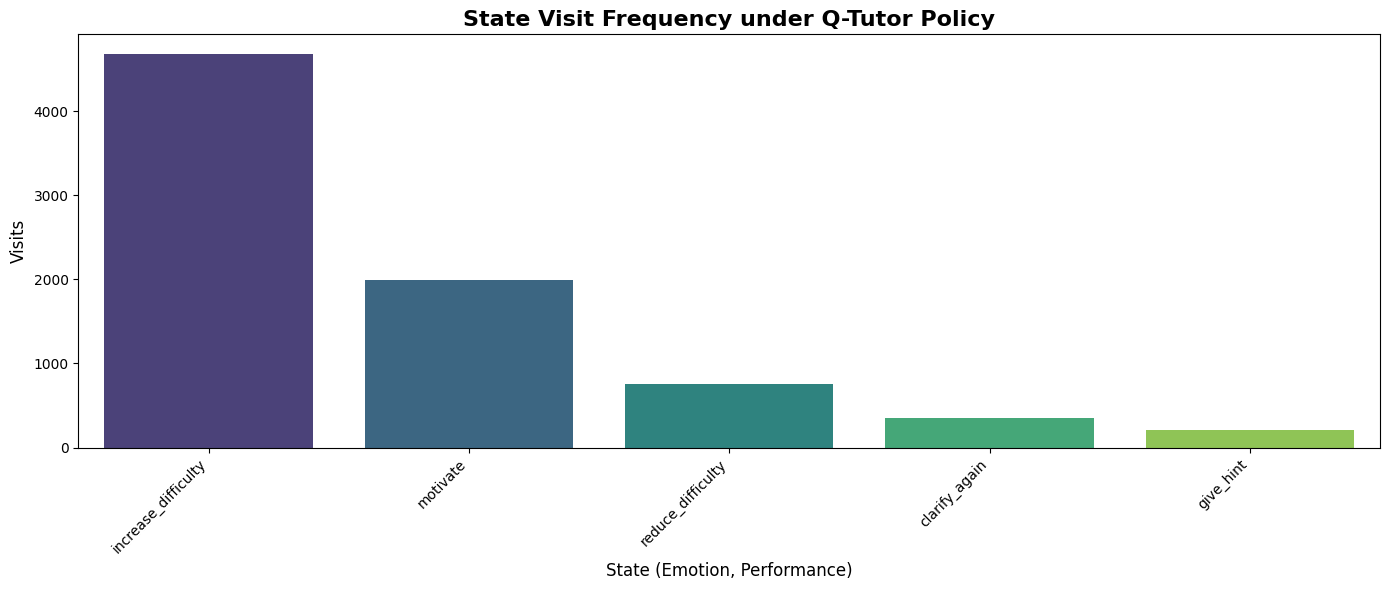

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter


state_visits = Counter()
for s, count in q_actions.items():
    state_visits[s] += count
state_labels = []
for s in state_visits.keys():

    if isinstance(s, tuple) or isinstance(s, list):
        state_labels.append(f"{str(s[0])}, {str(s[1])}")
    else:

        state_labels.append(str(s))


state_df = pd.DataFrame({
    'State': state_labels,
    'Visits': list(state_visits.values())
}).sort_values("Visits", ascending=False)


plt.figure(figsize=(14,6))
sns.barplot(x='State', y='Visits', data=state_df, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("State Visit Frequency under Q-Tutor Policy", fontsize=16, fontweight='bold')
plt.ylabel("Visits", fontsize=12)
plt.xlabel("State (Emotion, Performance)", fontsize=12)
plt.tight_layout()
plt.show()


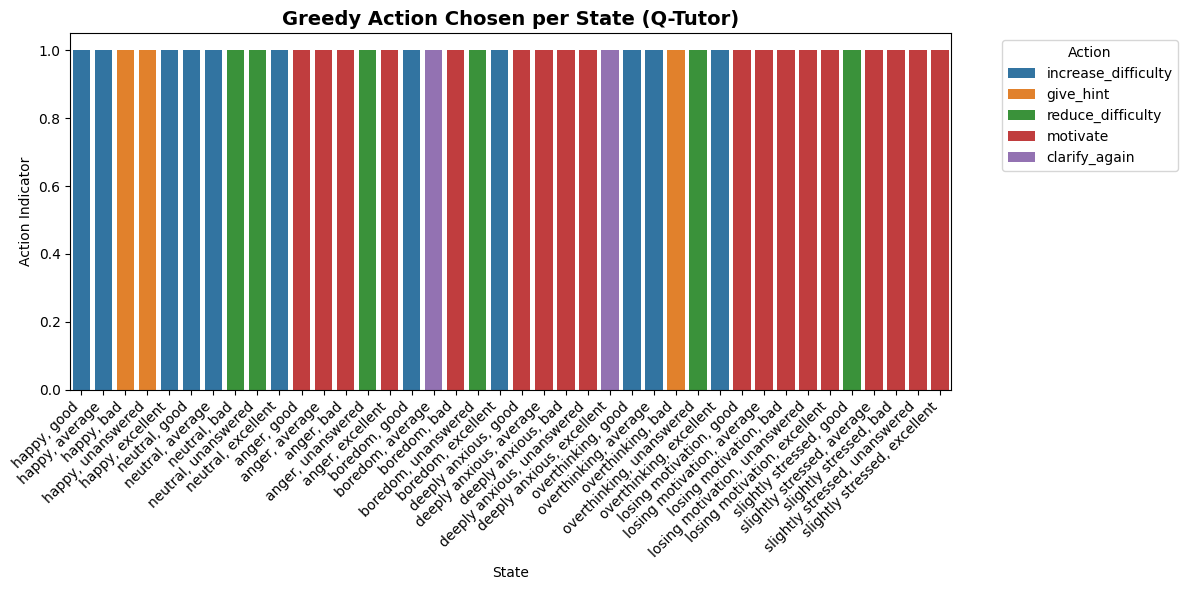

In [12]:
best_actions = [index_to_action[int(np.argmax(q_tutor.Q[i]))] for i in range(len(states))]

plt.figure(figsize=(12,6))
sns.barplot(x=[f"{s[0]}, {s[1]}" for s in states], y=[1]*len(states), hue=best_actions, dodge=False, palette="tab10")
plt.xticks(rotation=45, ha='right')
plt.title("Greedy Action Chosen per State (Q-Tutor)", fontsize=14, fontweight='bold')
plt.ylabel("Action Indicator")
plt.xlabel("State")
plt.legend(title="Action", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-126278571.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actions_list, y=counts_list, palette="coolwarm")


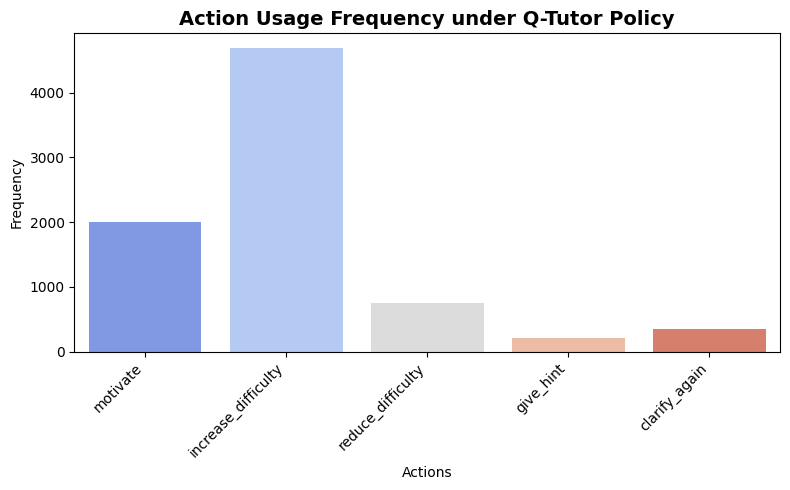

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
actions_list = list(q_actions.keys())
counts_list = list(q_actions.values())

plt.figure(figsize=(8,5))
sns.barplot(x=actions_list, y=counts_list, palette="coolwarm")
plt.title("Action Usage Frequency under Q-Tutor Policy", fontsize=14, fontweight='bold')
plt.ylabel("Frequency")
plt.xlabel("Actions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


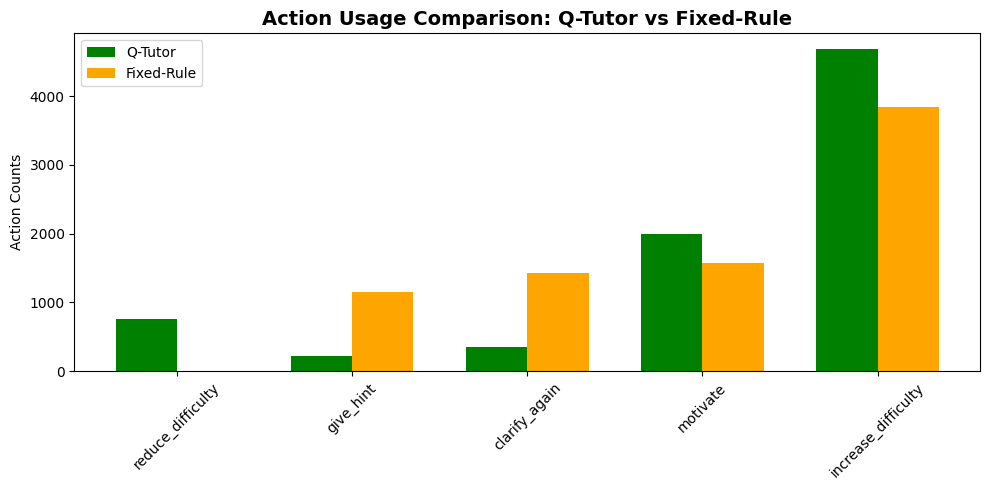

In [14]:
q_counts = dict(q_actions.most_common())
fixed_counts = dict(fixed_actions.most_common())
all_actions = list(set(q_counts.keys()).union(fixed_counts.keys()))

q_vals = [q_counts.get(a, 0) for a in all_actions]
fixed_vals = [fixed_counts.get(a, 0) for a in all_actions]

x = np.arange(len(all_actions))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, q_vals, width, label="Q-Tutor", color="green")
plt.bar(x + width/2, fixed_vals, width, label="Fixed-Rule", color="orange")
plt.xticks(x, all_actions, rotation=45)
plt.ylabel("Action Counts")
plt.title("Action Usage Comparison: Q-Tutor vs Fixed-Rule", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()
